# Stock Market prediction and Forecasting using stacked LSTM

In [1]:
### Data collection
# !pip install pandas_datareader
import pandas_datareader as pdr
import pandas as pd

In [2]:
# api = '38e0083d2ab77e29ea24f84c53f4f87d192d1f70'
# df = pdr.get_data_tiingo('AAPL',api_key = key) #read from tiingo
#df.to_csv('AAPL.csv') #store in local csv file

In [3]:
df = pd.read_csv("E:\datasets\AAPL.csv")

In [4]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [5]:
df.shape

(1258, 15)

In [6]:
df1 = df["close"]

In [7]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

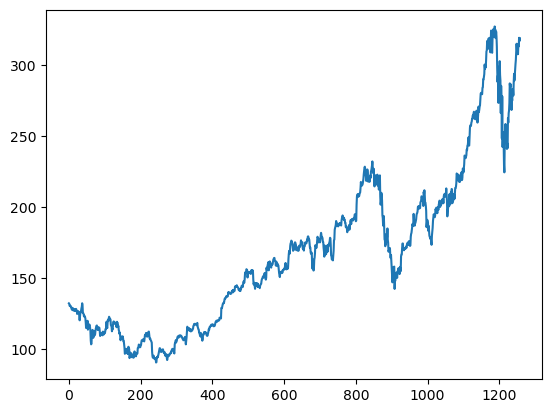

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [13]:
# split the data into train and test data
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:] 

In [14]:
training_size,test_size

(817, 441)

In [15]:
len(train_data),len(test_data)

(817, 441)

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0] 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
X_train ,y_train =  create_dataset(train_data, time_step = 100)
X_test, y_test   =  create_dataset(test_data,time_step = 100)

In [19]:
X_train.shape, y_train.shape

((716, 100), (716,))

In [20]:
X_test.shape, y_test.shape

((340, 100), (340,))

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [22]:
X_train.shape, X_test.shape

((716, 100, 1), (340, 100, 1))

In [23]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [27]:
model = Sequential()
model.add(LSTM(50, input_shape=(100, 1), return_sequences=True))  # Keep 3D output
model.add(LSTM(50))  # Now this LSTM layer gets proper 3D input
model.add(Dense(1))

model.compile(
    optimizer='adam',  # Fixed typo: "optimiser" → "optimizer"
    loss='mean_squared_error'  # Fixed typo: "mean_squred_error" → "mean_squared_error"
)

In [28]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(X_train,y_train,validation_data = (X_test, y_test), epochs = 100, verbose = 1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0220 - val_loss: 0.0159
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.7987e-04 - val_loss: 0.0031
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.8216e-04 - val_loss: 0.0033
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2440e-04 - val_loss: 0.0024
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.3298e-04 - val_loss: 0.0028
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.7119e-04 - val_loss: 0.0022
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 4.1541e-04 - val_loss: 0.0022
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.0555e-04 - val_loss: 0.0021
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 3.6167e-04 - val_loss: 0.0020
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5070e-04 - val_loss: 0.0019
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7062e-04 - val_loss: 0.0021
Epoch 12/10

In [30]:
import tensorflow as tf

In [31]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [32]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [33]:
### Calculate RMSE performance metrics for train predict
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

141.85078344438975

In [34]:
### Calculate RMSE performance metrics for test predict
math.sqrt(mean_squared_error(y_test, test_predict))

235.93163556431205

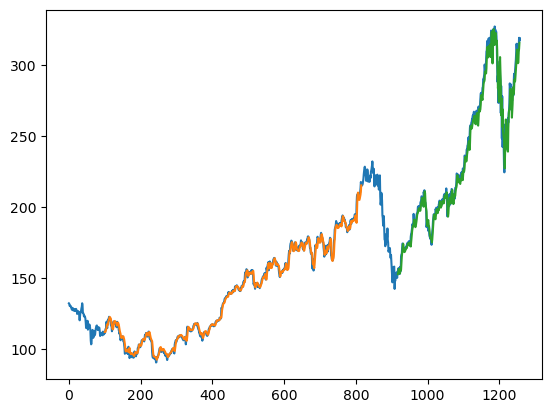

In [37]:
import numpy
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [38]:
len(test_data)

441

In [43]:
#taking previous 100 days data to predict next 30 days price
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [46]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [112]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.99016297 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007
 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017
 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113
 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013
 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193
 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292
 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832 0.83049059
 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543 0.78426074
 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843
 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415 0.92793211
 0.948535   0.93333615 0.91746179 0.92544119 0.91771511 0.9483239
 0.94064004 0.96635143 0.9563033  0.96491598 0.94395423 0.9250136
 0.90185368 0.87958467 0.86134815 0.84874284 0.84189641 0.83981007
 0.84083498 0.84312749 0.84502041 0.84528714 0.84328419 0.8389675
 0.83278853 0.82550812 0.81797802 0.8109445  0.804916

In [113]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [114]:
import matplotlib.pyplot as plt

In [115]:
len(df1)

1258

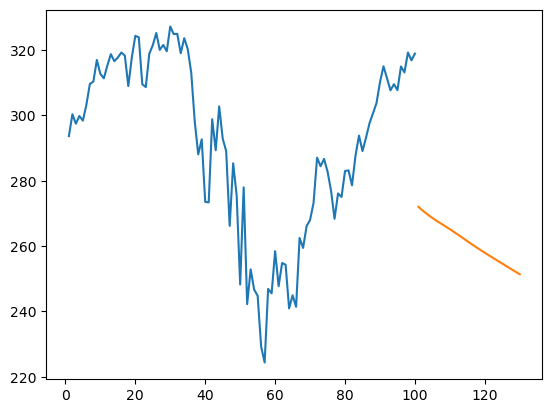

In [116]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

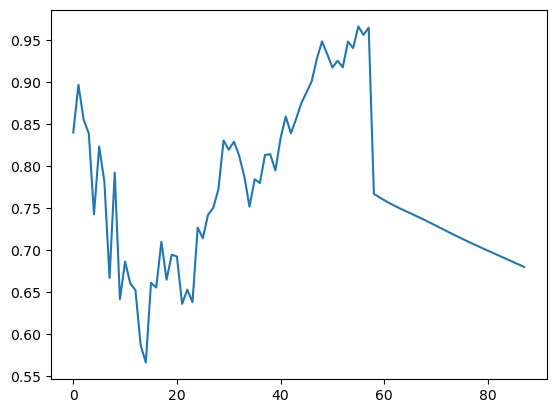

In [117]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [118]:
df3=scaler.inverse_transform(df3).tolist()

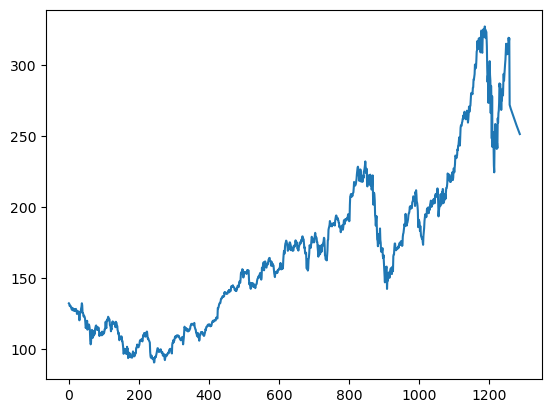

In [119]:
plt.plot(df3)